In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [2]:
# Eğitim ve doğrulama veri setlerini yükle
train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'valid',
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

# Sınıf isimleri
class_names = train_ds.class_names


Found 70295 files belonging to 38 classes.


2025-05-05 19:16:41.217469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-05 19:16:41.217601: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-05 19:16:41.217746: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-05 19:16:41.217825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 19:16:41.217872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 17572 files belonging to 38 classes.


In [3]:
# Mobilenet, 0-1 arası normalize edilmiş veriye ihtiyaç duyar
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Önce sadece son katmanları eğitelim

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # 38 sınıf
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10


2025-05-05 19:17:27.701307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 135s 60ms/step - accuracy: 0.4040 - loss: 2.4102 - val_accuracy: 0.8813 - val_loss: 0.3925
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 130s 59ms/step - accuracy: 0.8119 - loss: 0.6102 - val_accuracy: 0.9122 - val_loss: 0.2778
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 130s 59ms/step - accuracy: 0.8666 - loss: 0.4161 - val_accuracy: 0.9287 - val_loss: 0.2245
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 130s 59ms/step - accuracy: 0.8911 - loss: 0.3386 - val_accuracy: 0.9354 - val_loss: 0.2008
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 131s 60ms/step - accuracy: 0.9064 - loss: 0.2872 - val_accuracy: 0.9390 - val_loss: 0.1844
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 147s 67ms/step - accuracy: 0.9144 - loss: 0.2602 - val_accuracy: 0.9443 - val_loss: 0.1686
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 144s 65ms/step - accuracy: 0.9210 - loss: 0.2348 - val_accuracy: 0.9471 - val_loss: 0.1638
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 133s 61ms/step - accuracy: 0.9269 - lo

In [6]:
model.save('mobilenetv2_transfer_plant_model.keras')

with open('mobilenet_history.json', 'w') as f:
    json.dump(history.history, f)


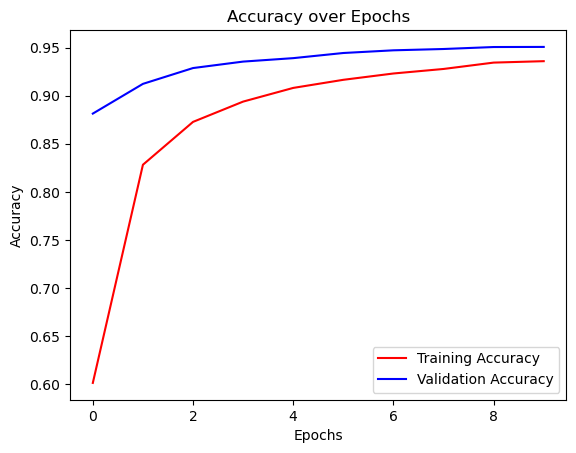

In [7]:
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


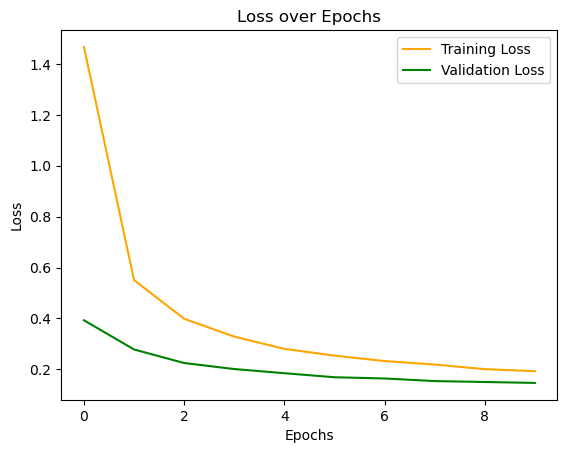

In [9]:
# Loss grafiği
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 17572 files belonging to 38 classes.
17572/17572 ━━━━━━━━━━━━━━━━━━━━ 287s 16ms/step


2025-05-05 19:45:55.922321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.97      0.96       504
                                 Apple___Black_rot       0.96      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.97      0.98       440
                                   Apple___healthy       0.98      0.96      0.97       502
                               Blueberry___healthy       0.98      0.99      0.98       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       421
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.83      0.89       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.87      0.97      0.

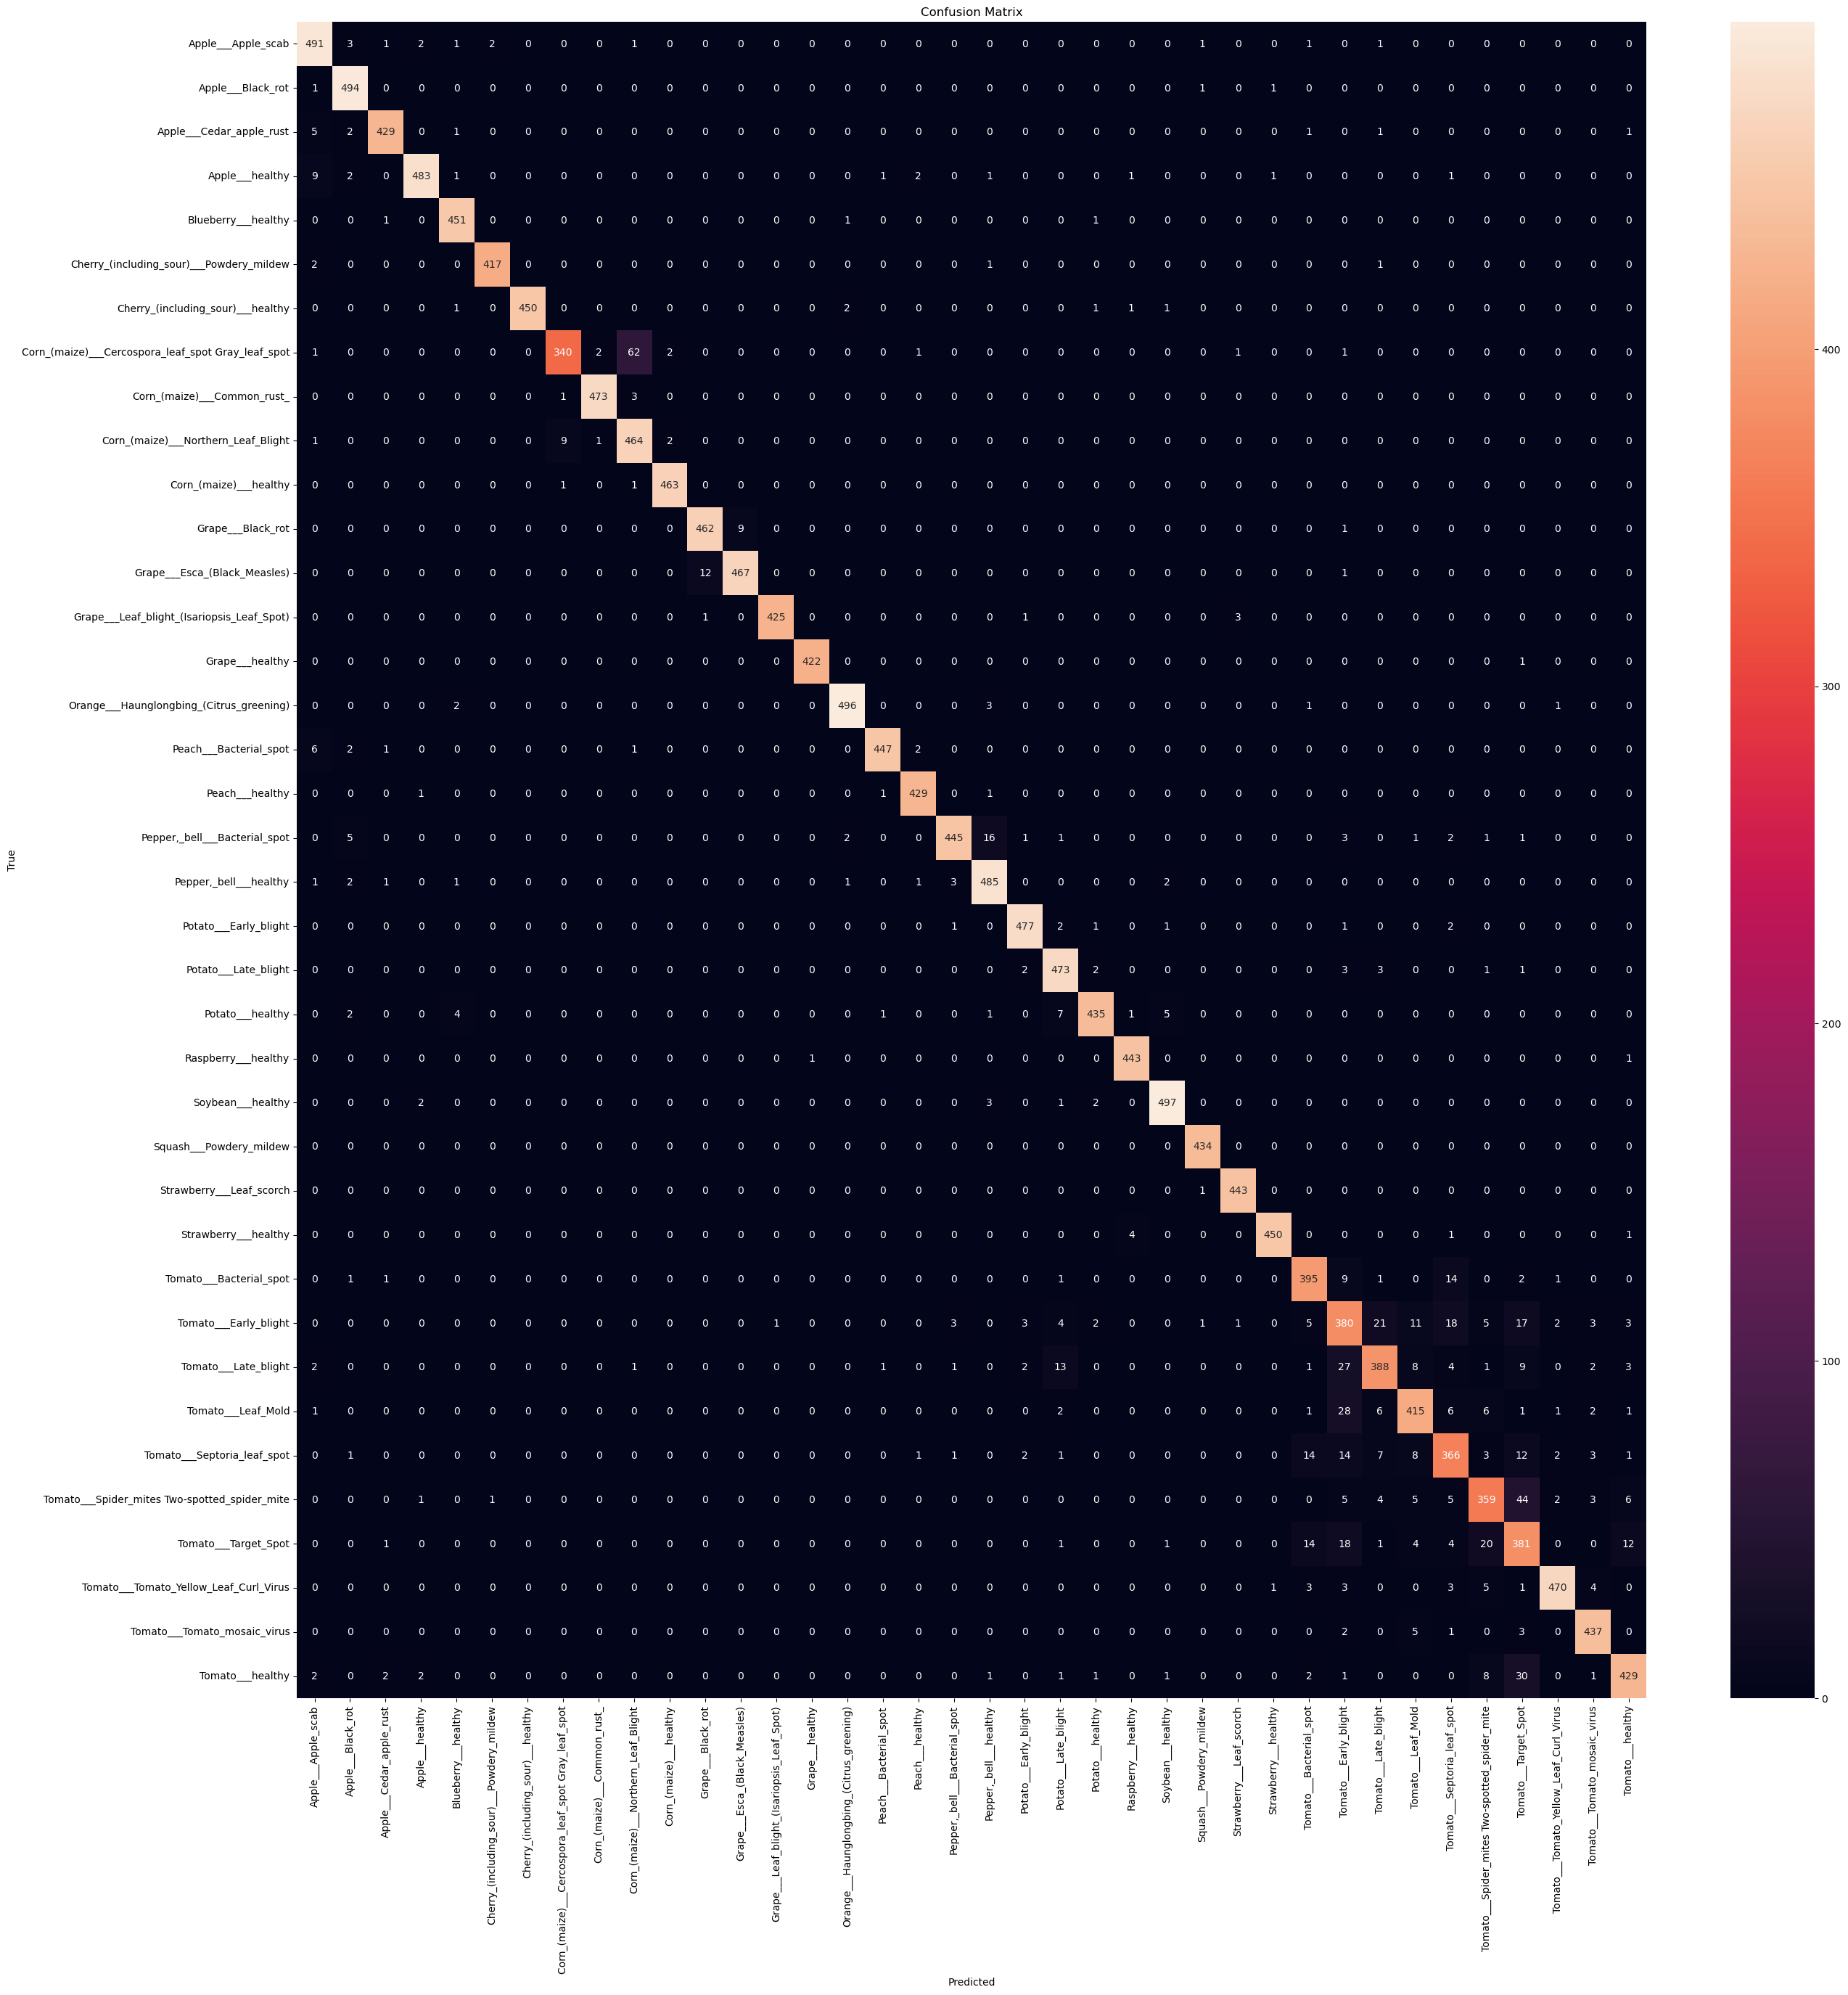

In [8]:
# Test verisi tek tek alınmalı (shuffle=False olmalı)
test_ds = tf.keras.utils.image_dataset_from_directory(
    'valid',
    image_size=(128, 128),
    batch_size=1,
    label_mode='categorical',
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Gerçek ve tahmin değerleri
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_classes = np.argmax(y_true, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


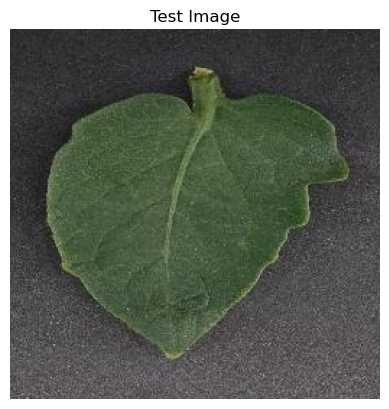

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Model Tahmini: Pepper,_bell___healthy


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Görüntü yolu
image_path = 'test/test/TomatoHealthy2.JPG'

# Görüntüyü oku ve göster
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Test Image')
plt.axis('off')
plt.show()

# Görüntüyü modele uygun şekilde hazırla (128x128 olacak!)
img_resized = cv2.resize(img_rgb, (128, 128))  # ← burası önemli!
img_array = img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Normalize işlemi

# Tahmin yap
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

print(f"Model Tahmini: {predicted_class}")

